# **ECSE 415 Project**
## Anas Deis | 260684605

In [1]:
# install dependencies: 
!pip install opencv-python==4.4.0.44
!pip install opencv-contrib-python==4.4.0.44
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# Restart Runtime after first run

1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



# **Part 1**

Mounted at /content/drive
path: /content/drive/My Drive/frames/


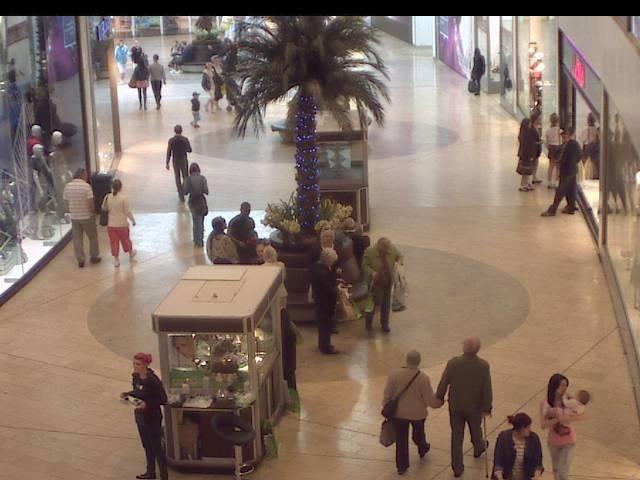

In [3]:
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/My Drive/'
path = root+'frames/'
print('path:', path)

img = cv2.imread(path+"seq_000001.jpg")
cv2_imshow(img)

In [4]:
# Adapted from source code: https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_d-m5
def detectron(img):
  cfg = get_cfg()
  # add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
  cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
  # Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
  predictor = DefaultPredictor(cfg)
  outputs = predictor(img)

  return outputs,cfg

outputs, cfg = detectron(img)

# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
classes = outputs["instances"].pred_classes.tolist()
boxes = outputs["instances"].pred_boxes.tensor.tolist()
print('labels:', classes)
print('bounding boxes [x1,y1,x2,y2]:', boxes)

model_final_f10217.pkl: 178MB [00:08, 21.5MB/s]                           


labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 26, 0, 0, 0, 0, 0, 0, 26, 0, 0, 0, 58, 0, 26]
bounding boxes [x1,y1,x2,y2]: [[64.45234680175781, 168.334716796875, 102.30838775634766, 269.1786804199219], [119.43522644042969, 349.715576171875, 170.9899444580078, 479.6225891113281], [99.86172485351562, 178.3436737060547, 137.74395751953125, 269.9278564453125], [433.6434631347656, 336.8468322753906, 493.7386474609375, 472.7662658691406], [514.2059936523438, 111.5212631225586, 542.030517578125, 192.01121520996094], [490.9833679199219, 411.91265869140625, 543.8982543945312, 478.2018737792969], [542.2893676757812, 127.29756164550781, 582.2747192382812, 218.82012939453125], [381.6629638671875, 348.3829345703125, 441.7508239746094, 470.7423400878906], [539.2769165039062, 373.095947265625, 590.9541015625, 477.1805725097656], [205.9933319091797, 215.9971923828125, 239.61183166503906, 264.3659362792969], [165.4770050048828, 124.48623657226562, 192.95437622070312, 196.43991088867188], [181.37

/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


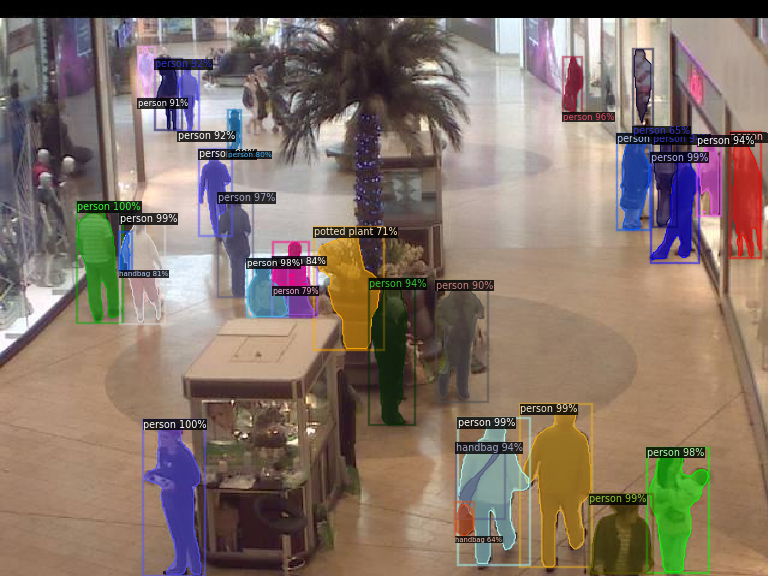

In [5]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [6]:
# No duplicates from detectron2 implementation
# Count the bounding boxes for person and print
persons = outputs["instances"].pred_classes.tolist()
count = 0
for person in persons: 
  if(person == 0): count+=1

print('# of bounding boxes for person:', count)

# of bounding boxes for person: 25


# **Part 2**

In [7]:
from sklearn import svm
from sklearn.metrics import accuracy_score
import random
import csv

In [8]:
# HoG from assignment 3 - slightly modified function
def compute_hog(images, img_size=(64,128)):

    # create HoG Object
    hog = cv2.HOGDescriptor()
    
    images_copy = []
    for image in images:
        images_copy.append(cv2.resize(image, img_size))
    images_copy = np.asarray(images_copy)

    features = []
    for i in range(images_copy.shape[0]):
        features.append(hog.compute(images_copy[i].astype(np.uint8)).reshape(1, -1))
    features = np.vstack(features)
    
    return features

In [9]:
# Sliding window function across the image from assignment 2 function
def sliding_window(img, step_size, window_size):
    for h in range(0, img.shape[0], step_size):
        for w in range(0, img.shape[1], step_size):
            # yield current window
            yield (w, h, img[h:h + window_size[1], w:w + window_size[0]])

In [10]:
# Check overlap between two detections of an image function
def get_overlap(img, pred, gt):
    """
    @brief Calculates the pixel overlap between two detections in an image
    @param img: ndarray. The input image where that has the two detections
    @param pred: [x1, y1, x2, y2]. Coordinates for the prediction
    @param gt: [x1, y1, x2, y2]. Coordinates for the ground truth 
    @return overlap: Overlap between 0 and 1, where 0 shows no overlap and 1 complete overlap
    """
    # create binary images with pixels set to False/True
    img_pred = np.full((img.shape[0], img.shape[1]), False)
    img_pred[pred[1]:pred[3],pred[0]:pred[2]] = True

    img_gt = np.full((img.shape[0], img.shape[1]), False)
    img_gt[gt[1]:gt[3],gt[0]:gt[2]] = True

    # perform bitwise AND operation to compute overlap
    result = np.bitwise_and(img_gt, img_pred)
    overlap = np.sum(result) / np.sum(img_gt)

    # return the sum of array (number of 1s)
    return overlap

In [11]:
# Get negative patches function
def get_neg_patches(img, pos_coordinates, step_size=16, window_size=(64, 128)):
  """
  @brief Extract the negative samples from an image
  @param img: ndarray. The image to extract negative patches from
  @param step_size: number. Step size for sliding window. Default: 16
  @param window_size: (w,h). Window size (width,height) for sliding window. Default: (64,128)
  @param pos_coordinates: [x1, y1, x2, y2] list. Positive coordinates to  check for overlap 
  @return neg_patches: list. The negative patches
  @return img_copy: ndarray. Optional. Used to display the image with rectangles
  """
  neg_patches = []
  img_copy = img.copy() # for display
  for (x, y, window) in sliding_window(img, step_size=step_size, window_size=window_size):
    neg_patch = img[y:y+window_size[1], x:x+window_size[0]]

    overlap = 0  #initialize
    for pos_coordinate in pos_coordinates: #check for every window if there is overlap with positive samples
      overlap += get_overlap(img, [x,y,x+window_size[0],y+window_size[1]], pos_coordinate)

    if(overlap == 0): # no overlap, then extract negative patch and append
      neg_patches.append(neg_patch)

    # for display 
    img_copy = cv2.rectangle(img_copy, (x, y), (x + window_size[0], y + window_size[1]), (255, 0, 0), 2)

  return neg_patches, img_copy

In [12]:
# Get positive patches function
def get_pos_patches(img):
  """
  @brief Extract the negative samples from an image
  @param img: ndarray. The image to extract positive patches from
  @return pos_patches: list. The negative patches
  @return img_copy: ndarray. Used to display the image with rectangles
  """
  pos_patches = []
  pos_coordinates = []
  outputs,_ = detectron(img) # use the person detector implemented in part 1 to identify the person patches in each image.
  boxes = outputs["instances"].pred_boxes.tensor.tolist() # get list of boundary boxes for person with format array([x1,y1,x2,y2],...)
  for i,person in enumerate(outputs["instances"].pred_classes.tolist()):
    if(person == 0): # if boundary is person (label = 0)
      box = boxes[i] # get boundary box coordinates for person 
      x1=round(box[0])
      y1=round(box[1])
      x2=round(box[2])
      y2=round(box[3])
      patch = img[y1:y2, x1:x2] # extract positive patch
      pos_coordinates.append([x1,y1,x2,y2])  # append coordinates to use for negative patches
      pos_patches.append(patch) # append patch to the array of positive patches

  return pos_patches, pos_coordinates

In [13]:
# Get random images frames/seq_XXXXXX.jpg function
def get_random_images(num_images):
  """
  @brief Get a list of images at random from frames/seq_XXXXXX.jpg
  @param num_images: number. The number of images to retrieve
  @return images: ndarray. The retrieved images
  @return filenames: list. The names of retrieved images
  """

  # Store images randomly from 2000 samples in frames/seq_XXXXXX.jpg
  images = [] # store images
  filenames = [] # store filenames
  for i in random.sample(range(1, 2001), num_images): 
    name = "seq_" + str(i).zfill(6) + ".jpg"
    filenames.append(name)
    images.append(cv2.imread(path+name))

  # Convert images to np array
  images = np.asarray(images)

  # Print
  print('selected images shape:', images.shape)
  print('selected images filenames:', filenames)

  return images, filenames

In [14]:
# Write CSV file using template function
def write_csv(dict):
  """
  @brief Write CSV file with id and count as headers
  @param dict: dictionary. Data to input in the CSV file as dictionary with keys: 'id', 'count'
  """   
  # field names  
  fields = ['id', 'count']  
      
  # name of csv file  
  filename = root+'DeisAnas_submission.csv'
      
  # writing to csv file  
  with open(filename, 'w') as csvfile:  
      # creating a csv dict writer object  
      writer = csv.DictWriter(csvfile, fieldnames = fields)  
          
      # writing headers (field names)  
      writer.writeheader()  
          
      # writing data rows  
      writer.writerows(dict)  

  print('Writing csv file to {}DeisAnas_submission.csv'.format(root))

In [15]:
# Get IoU function
def get_iou(box, boxes):
  """
  @brief Implement the Intersection-over-Union (IoU) between box and boxes
  @param box: [x1, y1, x2, y2] ndarray. Coordinates for the first box
  @param boxes: N x [x1, y1, x2, y2] ndarray. Coordinates for the second box
  @return IoU
  """
  # Calculate the [x1, y1, x2, y2] coordinates of the intersection of rectangles
  x1 = np.maximum(box[0], boxes[:, 0])
  y1 = np.maximum(box[1], boxes[:, 1])
  x2 = np.minimum(box[2], boxes[:, 2])
  y2 = np.minimum(box[3], boxes[:, 3])
  inter_areas = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)

  # Calculate the union area by using the formula: Union(A,B) = A + B - Inter(A,B)
  box_area = (box[3] - box[1]) * (box[2] - box[0])
  boxes_area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
  union_areas = box_area + boxes_area - inter_areas
  
  # compute the IoU
  iou = inter_areas / union_areas

  return iou

In [16]:
# Compute non-maximum suppression using IoU function
def nms(boxes, scores, overlap_th=0.3):
  """
  @brief Implement the Non-Maximum Suppression technique to clean up prediction from duplicates.
  @param scores: ndarray. List of scores for boxes
  @param boxes: N x [x1, y1, x2, y2] ndarray. Coordinates for boxes
  @param overlap_th: number. Overlap threshold to supress the boxes with high IoU with respect to the previoulsy selected one. Default: 0.3
  @return indices of boundary boxes
  """
  # If boxes is empty, return empty list
  if len(boxes) == 0:
    return []

  # Initialize
  boxes_idx = []
  
  # Sort the indices by the score
  indices = np.argsort(scores)

  # loop so long as there are still indices in the list
  while len(indices) > 0:

    # Select the index with highest score and append to 
    last = len(indices) - 1
    idx = indices[last]
    boxes_idx.append(idx)
    
    # Get the IoU between the box with highest score and the boxes remained in the indices list
    overlap = get_iou(boxes[idx], boxes[indices[:last]])

    # delete all indices from the index list with overlap > overlap_th
    indices = np.delete(indices, np.concatenate(([last], np.where(overlap > overlap_th)[0])))

  # return indices of selected boundary boxes
  return boxes_idx

In [17]:
# Detect persons using SVM classifier function
def detect_svm(images, clf, step_size=16, window_size=(64,128), cfd_lvl=30, overlap_th=0.3, display=False):
  """
  @brief Detect persons using SVM classifier.
  @param images: ndarray. List of images
  @param clf: SVC classifier.
  @param step_size: number. Step size for sliding window. Default: 16
  @param window_size: (w,h). Window size (width,height) for sliding window. Default: (64,128)
  @param cfd_lvl: number. Confidence level for filtering boundary boxes before NMS. Default: 30
  @param overlap_th: number. Overlap threshold to use for NMS. Default: 0.3
  @return array of count of persons for every image
  """
  person_count = []

  for idx,img in enumerate(images):
    # Initialize
    boxes_list = []
    pred_boxes_list = []
    pred_scores_list = []
    if (display == True): img_copy = img.copy()

    outputs, _ = detectron(img)
    classes = outputs["instances"].pred_classes.tolist()
    boxes = outputs["instances"].pred_boxes.tensor.tolist()

    for i,label in enumerate(classes):
      if(label == 0):
        boxes_list.append(boxes[i])

    # Use trained classifier to detect persons 
    for (x, y, window) in sliding_window(img, step_size=step_size, window_size=window_size):
      pred = img[y:y+window_size[1], x:x+window_size[0]] # extract cropped window image
      pred = np.expand_dims(pred, axis=0) # expand array by one dimension to compute HoG
      pred = compute_hog(pred) # compute HoG of window
      person = clf.predict(pred) # get prediction 

      if(person[0] == 1): # if prediction is person
        score = (get_iou([x,y,x+window_size[0],y+window_size[1]], np.asarray(boxes_list))*100) # use IoU metric to score how well detector works compared to ground truth
        score_max = int(round(np.amax(score))) # get the maximum score to get relevant bounding box of ground truth, i.e. discard overlaps from other bounding boxes
        if (score_max > cfd_lvl): # filter before NMS by setting a confidence level for better results
          pred_boxes_list.append([x,y,x+window_size[0],y+window_size[1]])
          pred_scores_list.append(score_max)
          if (display == True):
            label = 'person ' + str(score_max) + '%'
            img_copy = cv2.rectangle(img_copy, (x, y), (x + window_size[0], y + window_size[1]), (255, 0, 0), 2)
            img_copy = cv2.putText(img_copy,label,(x,y),cv2.FONT_HERSHEY_COMPLEX,0.4,(255,255,255),1)

    # Compute NMS to remove duplicates
    boxes_idx = nms(np.asarray(pred_boxes_list), np.asarray(pred_scores_list), overlap_th) 
    person_count.append(len(boxes_idx))

    # Draw bounding boxes
    if (display == True):
      print(idx, '- Display before NMS:')
      cv2_imshow(img_copy)  

      print(idx, '- Display after NMS:')
      img_copy = img.copy()
      for idx in boxes_idx:
        x1 = pred_boxes_list[idx][0]
        y1 = pred_boxes_list[idx][1]
        x2 = pred_boxes_list[idx][2]
        y2 = pred_boxes_list[idx][3]
        label = 'person ' + str(pred_scores_list[idx]) + '%'
        img_copy = cv2.rectangle(img_copy, (x1, y1), (x2, y2), (255, 0, 0), 2)
        img_copy = cv2.putText(img_copy,label,(x1,y1),cv2.FONT_HERSHEY_COMPLEX,0.4,(255,255,255),1)

      cv2_imshow(img_copy) 

  return person_count

In [18]:
num_images = 100

# Get training images
images, filenames = get_random_images(num_images)

selected images shape: (100, 480, 640, 3)
selected images filenames: ['seq_000112.jpg', 'seq_000018.jpg', 'seq_001596.jpg', 'seq_001140.jpg', 'seq_000862.jpg', 'seq_000665.jpg', 'seq_000627.jpg', 'seq_000900.jpg', 'seq_000003.jpg', 'seq_001562.jpg', 'seq_001343.jpg', 'seq_001054.jpg', 'seq_001555.jpg', 'seq_000063.jpg', 'seq_000463.jpg', 'seq_001538.jpg', 'seq_000893.jpg', 'seq_001996.jpg', 'seq_001176.jpg', 'seq_000218.jpg', 'seq_001079.jpg', 'seq_000130.jpg', 'seq_001341.jpg', 'seq_001869.jpg', 'seq_001789.jpg', 'seq_001005.jpg', 'seq_001032.jpg', 'seq_000317.jpg', 'seq_001938.jpg', 'seq_000351.jpg', 'seq_000878.jpg', 'seq_001302.jpg', 'seq_000936.jpg', 'seq_000491.jpg', 'seq_001128.jpg', 'seq_000238.jpg', 'seq_001404.jpg', 'seq_001532.jpg', 'seq_000919.jpg', 'seq_001242.jpg', 'seq_001400.jpg', 'seq_000602.jpg', 'seq_000730.jpg', 'seq_001924.jpg', 'seq_001994.jpg', 'seq_000453.jpg', 'seq_000984.jpg', 'seq_000113.jpg', 'seq_000584.jpg', 'seq_000653.jpg', 'seq_000056.jpg', 'seq_000612.

In [19]:
# Training
# Extract positive patches from images array using the person detector 
# implemented in part 1 to identify the person patches in each image.
# Then extract negative patches using sliding window wihout overlapping 
# positive patches coordinates.

# Initialize
pos_patches_list = []
neg_patches_list = []
img_disp = []

# Iterate to get training samples
for image in images:
  pos_patches, pos_coordinates = get_pos_patches(image)
  pos_patches_list.extend(pos_patches) # append patch to the array of positive patches
  neg_patches, img_disp = get_neg_patches(image, pos_coordinates, step_size=32)
  neg_patches_list.extend(neg_patches) # append patch to the array of negative patches

# Join positive and negative samples to get features to use for training
features_train = pos_patches_list.copy()
features_train.extend(neg_patches_list)
features_train = np.asarray(features_train)

# Convert positive and negative samples to np arrays
pos_patches_list = np.asarray(pos_patches_list)
neg_patches_list = np.asarray(neg_patches_list)

# Set positive labels to 1 and negative labels to 0, then join
pos_labels = np.ones(pos_patches_list.shape[0], dtype=int)
neg_labels = np.zeros(neg_patches_list.shape[0], dtype=int)
labels_train = np.concatenate((pos_labels, neg_labels))

# Print
print('# of positive training samples:', pos_patches_list.shape[0])
print('# of negative training samples:', neg_patches_list.shape[0])
print('# of training features:', features_train.shape[0])

# of positive training samples: 2299
# of negative training samples: 11719
# of training features: 14018


Display 9 random positive samples:


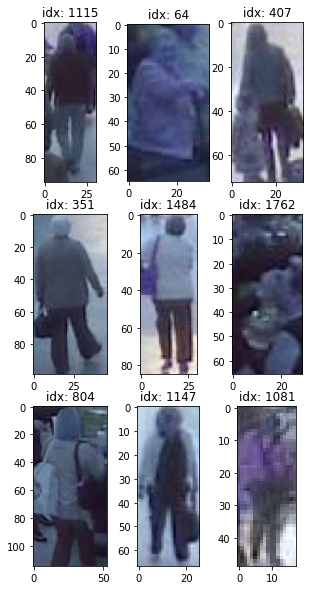

In [20]:
# Print
print('Display 9 random positive samples:')

i = 0
plt.figure(figsize=(5,10))
for index in random.sample(range(0, pos_patches_list.shape[0]), 9): 
  i+=1
  plt.subplot(330 + i), plt.imshow(pos_patches_list[index])
  plt.title("idx: {}".format(index))
plt.show()

Display 9 random negative samples:


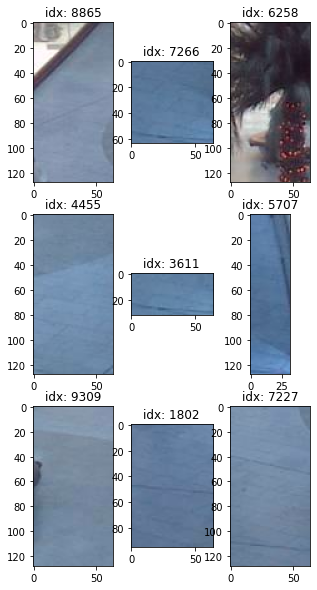

In [21]:
# Print
print('Display 9 random negative samples:')

i = 0
plt.figure(figsize=(5,10))
for index in random.sample(range(0, neg_patches_list.shape[0]), 9): 
  i+=1
  plt.subplot(330 + i), plt.imshow(neg_patches_list[index])
  plt.title("idx: {}".format(index))
plt.show()

Display the last image to show the process of extracting negative patches: seq_000805.jpg


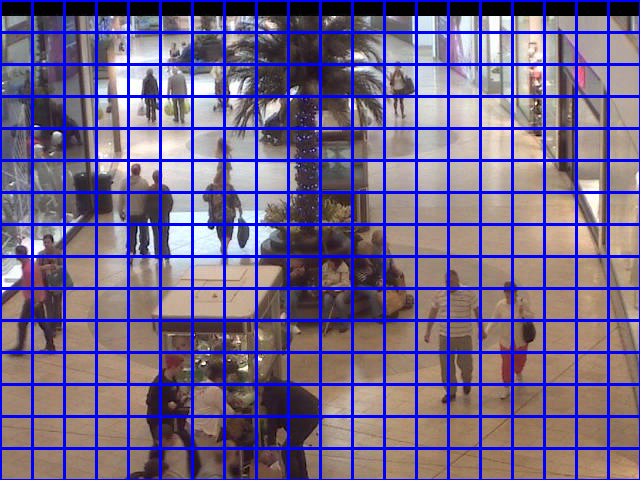

In [22]:
# Print
print("Display the last image to show the process of extracting negative patches:", filenames[num_images-1])
cv2_imshow(img_disp)

In [23]:
num_images = 5

# Get testing images
images, _ = get_random_images(num_images)

selected images shape: (5, 480, 640, 3)
selected images filenames: ['seq_000595.jpg', 'seq_001475.jpg', 'seq_000086.jpg', 'seq_000139.jpg', 'seq_000002.jpg']


In [24]:
# Testing
# Extract positive patches from images array using the person detector 
# implemented in part 1 to identify the person patches in each image.
# Then extract negative patches using sliding window wihout overlapping 
# positive patches coordinates.

# Initialize
pos_patches_test = []
neg_patches_test = []

# Iterate to get testing samples
for image in images:
  pos_patches, pos_coordinates = get_pos_patches(image)
  pos_patches_test.extend(pos_patches) # append patch to the array of positive patches
  neg_patches, _ = get_neg_patches(image, pos_coordinates, step_size=32)
  neg_patches_test.extend(neg_patches) # append patch to the array of negative patches

# Join positive and negative samples to get features to use for testing
features_test = pos_patches_test.copy()
features_test.extend(neg_patches_test)
features_test = np.asarray(features_test)

# Convert positive and negative samples to np arrays
pos_patches_test = np.asarray(pos_patches_test)
neg_patches_test = np.asarray(neg_patches_test)

# Set positive labels to 1 and negative labels to 0, then join
pos_labels_test = np.ones(pos_patches_test.shape[0], dtype=int)
neg_labels_test = np.zeros(neg_patches_test.shape[0], dtype=int)
labels_test = np.concatenate((pos_labels_test, neg_labels_test))

# Print
print('# of positive testing samples:', pos_patches_test.shape[0])
print('# of negative testing samples:', neg_patches_test.shape[0])
print('# of testing features:', features_test.shape[0])

# of positive testing samples: 119
# of negative testing samples: 575
# of testing features: 694


In [25]:
# Get suitable features for train and test samples
features_train = compute_hog(features_train)
features_test = compute_hog(features_test)

In [26]:
# Feed suitable features into SVM
clf = svm.SVC(gamma='auto', C = 100) 
clf.fit(features_train, labels_train)

# Print
print("Predicted Label:", clf.predict(features_test))
print("Actual Label:", labels_test)
print("Accuracy: %.2f %%" % (accuracy_score(labels_test,clf.predict(features_test))*100))

Predicted Label: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0

selected images shape: (3, 480, 640, 3)
selected images filenames: ['seq_001971.jpg', 'seq_000859.jpg', 'seq_001985.jpg']
0 - Display before NMS:


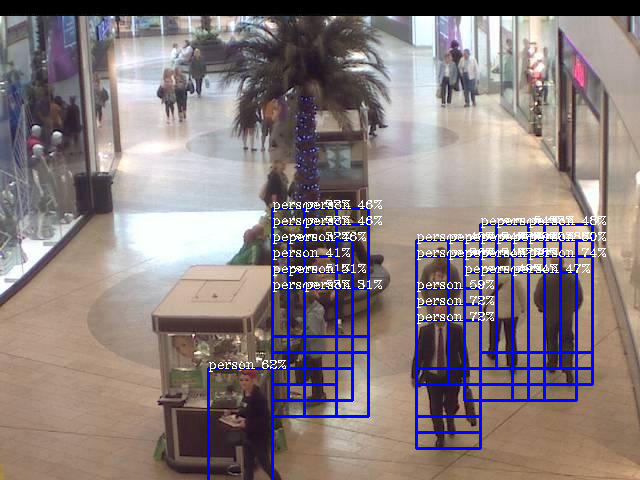

0 - Display after NMS:


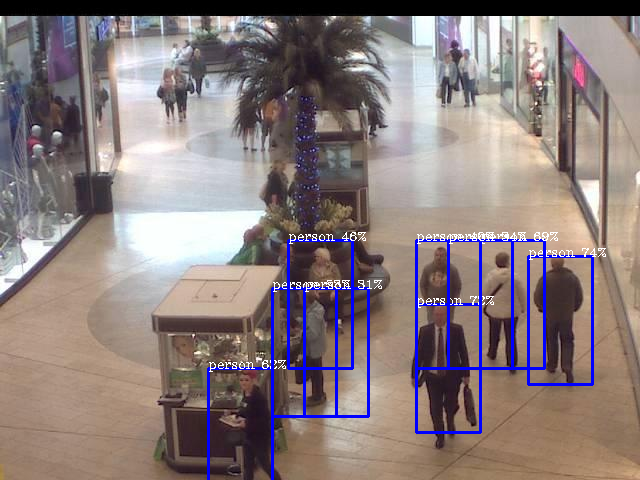

1 - Display before NMS:


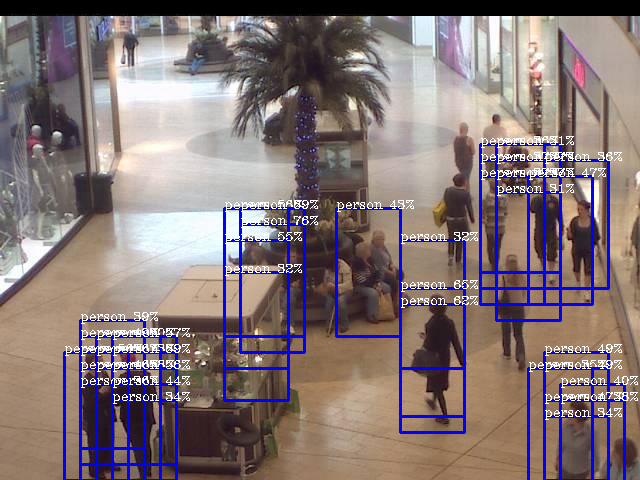

1 - Display after NMS:


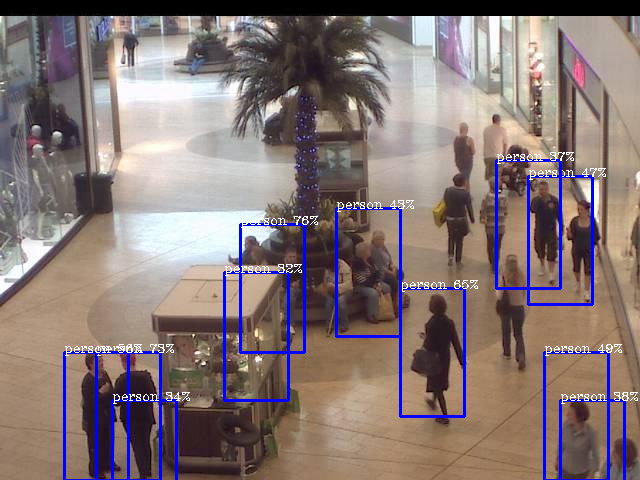

2 - Display before NMS:


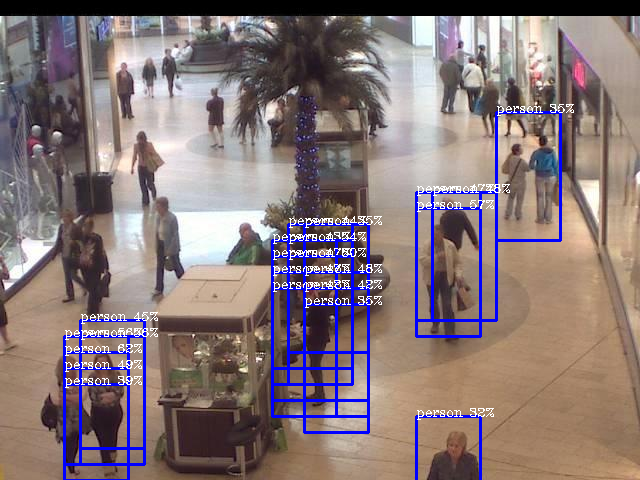

2 - Display after NMS:


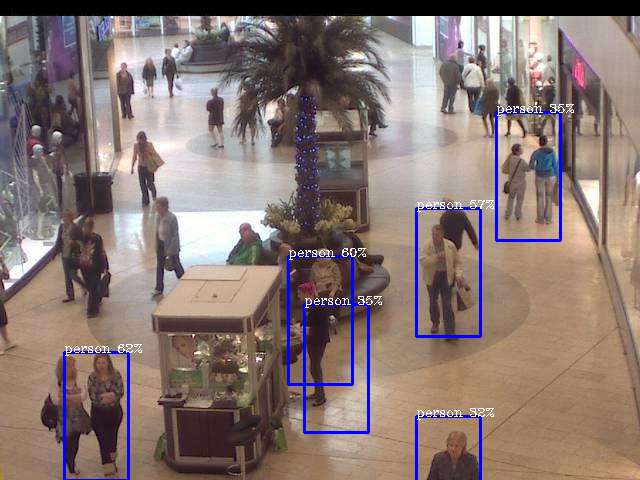

[9, 11, 6]

In [27]:
# Display some examples of person detection using SVM
images, _ = get_random_images(3)
detect_svm(images, clf, cfd_lvl=30, overlap_th=0.35, display=True)

In [28]:
# Store all 2000 images from frames/seq_XXXXXX.jpg
images = [] # store images
for i in range(1, 2001): 
  name = "seq_" + str(i).zfill(6) + ".jpg"
  images.append(cv2.imread(path+name))

# Convert images to np array
images = np.asarray(images)

person_count = detect_svm(images, clf, cfd_lvl=30, overlap_th=0.35)

In [30]:
# Write to CSV file
csv_list = []
for id,count in enumerate(person_count):
  id += 1
  csv_list.append({"id" : id, "count" : count})

print('CSV data:', csv_list)
write_csv(csv_list)

CSV data: [{'id': 1, 'count': 15}, {'id': 2, 'count': 12}, {'id': 3, 'count': 12}, {'id': 4, 'count': 11}, {'id': 5, 'count': 15}, {'id': 6, 'count': 14}, {'id': 7, 'count': 9}, {'id': 8, 'count': 9}, {'id': 9, 'count': 8}, {'id': 10, 'count': 11}, {'id': 11, 'count': 4}, {'id': 12, 'count': 1}, {'id': 13, 'count': 4}, {'id': 14, 'count': 13}, {'id': 15, 'count': 4}, {'id': 16, 'count': 10}, {'id': 17, 'count': 7}, {'id': 18, 'count': 9}, {'id': 19, 'count': 12}, {'id': 20, 'count': 13}, {'id': 21, 'count': 13}, {'id': 22, 'count': 6}, {'id': 23, 'count': 11}, {'id': 24, 'count': 8}, {'id': 25, 'count': 8}, {'id': 26, 'count': 6}, {'id': 27, 'count': 5}, {'id': 28, 'count': 4}, {'id': 29, 'count': 8}, {'id': 30, 'count': 6}, {'id': 31, 'count': 11}, {'id': 32, 'count': 9}, {'id': 33, 'count': 8}, {'id': 34, 'count': 5}, {'id': 35, 'count': 7}, {'id': 36, 'count': 5}, {'id': 37, 'count': 2}, {'id': 38, 'count': 6}, {'id': 39, 'count': 8}, {'id': 40, 'count': 7}, {'id': 41, 'count': 5}, 